<a href="https://colab.research.google.com/github/tharun067/python_problems/blob/main/AD(08_03_25).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks

GANs, or Generative Adversarial Networks, are a type of neural network architecture that allow neural networks to generate data. In the past few years, they’ve become one of the hottest subfields in deep learning, going from generating fuzzy images of digits to photorealistic images of faces.

GANs learn a probability distribution of a dataset by pitting two neural networks against each other.
- One model, the **generator**, tries to create images that look very similar to the dataset.
- The other model, the **discriminator**, tries to detect whether the images generated were fake or not.

<img style="float: center;" src='images/gan1.png' width=500 height=400 caption="Feed Forward NN">

Training generative adversarial networks involve two objectives:
1. The discriminator maximizes the probability of assigning the correct label to both training examples and images generated by the generator.
2. The generator minimizes the probability that the discriminator can predict that what it generates is fake. i.e the generator becomes better at creating fakes.

We'll be using the MNIST, a dataset of handwritten digits to implement GAN.

In [1]:
!pip install keras

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow import keras
from keras.layers import Input, Dense, Dropout, LeakyReLU
from keras.models import Model, Sequential
from keras.datasets import mnist
# from keras.optimizers import Adam
from keras.optimizers import Adam
from keras import initializers

In [3]:
np.random.seed(10) # reproduction

# The dimension of our random noise vector.
random_dim = 100

In [4]:
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784)
    # so we have 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

The generator also needs random input vectors to generate images, and for this, we’ll be using numpy.

**The GAN Function**

The GAN plays a minimax game, where the entire network attempts to optimize the function V(D,G). This is the equation that defines what a GAN is doing:
<img style="float: center;" src='images/gan2.png' width=500 height=450 caption="Feed Forward NN">

Now to anyone who isn’t well versed in the math behind it, it looks terrifying, but the idea it represents is simple, yet powerful. It’s just a mathematical representation of the two objectives as defined above.

The generator is defined by G(z), which converts some noise z we input into some data, like images.

The discriminator is defined by D(x), which outputs the probability that the input x came from the real dataset or not.

We want the predictions on the dataset by the discriminator to be as close to 1 as possible, and on the generator to be as close to 0 as possible. To achieve this, we use the log-likelihood of D(x) and 1-D(z) in the objective function. The log just makes sure that the closer it is to an incorrect value, the more it is penalized.

In [5]:
def get_optimizer():
    return Adam(learning_rate=0.0002, beta_1=0.5)

In [6]:
def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, \
            kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

The generator is just a vanilla neural network model that takes a random input vector and outputs a 784-dim vector, which, when reshaped, becomes a 28*28 pixel image.

In [7]:
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, \
                kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

The discriminator is another neural network that takes the output of the previous network, a 784-dimensional vector, and outputs a probability between 0 and 1 that it came from the training dataset.

**Compiling it into a GAN**

In [8]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [9]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), \
                          figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', \
                   cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

We now compile both models into a single adversarial network, setting the input as a 100-dimensional vector, and the output as the output of the discriminator.

In [12]:
def train(epochs=1, batch_size=128):

    #1 Get the training and testing data
    tf.config.run_functions_eagerly(True)
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] / batch_size

    #2. Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    # 3
    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(int(batch_count))):
            # 4. Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], \
                                                    size=batch_size)]

            # 5. Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # 6. Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            #7. Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            #8. Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            gan.compile(loss='binary_crossentropy', optimizer=get_optimizer())
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


--------------- Epoch 1 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 1/468 [00:00<07:05,  1.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 2/468 [00:01<06:06,  1.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  1%|          | 3/468 [00:02<06:02,  1.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  1%|          | 4/468 [00:02<05:23,  1.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|          | 5/468 [00:03<04:48,  1.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  1%|▏         | 6/468 [00:04<04:37,  1.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  1%|▏         | 7/468 [00:04<04:29,  1.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  2%|▏         | 8/468 [00:05<04:24,  1.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  2%|▏         | 9/468 [00:05<04:09,  1.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  2%|▏         | 10/468 [00:06<04:13,  1.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  2%|▏         | 11/468 [00:06<04:01,  1.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  3%|▎         | 12/468 [00:07<03:54,  1.94it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  3%|▎         | 13/468 [00:07<03:47,  2.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  3%|▎         | 14/468 [00:08<03:48,  1.99it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  3%|▎         | 15/468 [00:08<03:54,  1.93it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  3%|▎         | 16/468 [00:09<04:00,  1.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  4%|▎         | 17/468 [00:09<03:52,  1.94it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  4%|▍         | 18/468 [00:10<03:48,  1.97it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|▍         | 19/468 [00:10<03:55,  1.90it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  4%|▍         | 20/468 [00:11<03:52,  1.93it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  4%|▍         | 21/468 [00:11<03:56,  1.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  5%|▍         | 22/468 [00:12<03:50,  1.93it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|▍         | 23/468 [00:13<04:19,  1.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  5%|▌         | 24/468 [00:13<04:39,  1.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  5%|▌         | 25/468 [00:14<04:51,  1.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  6%|▌         | 26/468 [00:15<04:42,  1.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  6%|▌         | 27/468 [00:15<04:22,  1.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  6%|▌         | 28/468 [00:16<04:17,  1.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|▌         | 29/468 [00:16<04:06,  1.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|▋         | 30/468 [00:17<04:06,  1.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 31/468 [00:17<04:04,  1.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  7%|▋         | 32/468 [00:18<03:53,  1.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 33/468 [00:18<03:45,  1.93it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  7%|▋         | 34/468 [00:19<03:49,  1.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 35/468 [00:19<03:53,  1.86it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  8%|▊         | 36/468 [00:20<03:57,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  8%|▊         | 37/468 [00:20<03:49,  1.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  8%|▊         | 38/468 [00:21<03:53,  1.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  8%|▊         | 39/468 [00:21<03:42,  1.93it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  9%|▊         | 40/468 [00:22<03:36,  1.98it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  9%|▉         | 41/468 [00:22<03:42,  1.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|▉         | 42/468 [00:23<03:48,  1.86it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  9%|▉         | 43/468 [00:24<03:50,  1.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  9%|▉         | 44/468 [00:24<03:55,  1.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|▉         | 45/468 [00:25<04:10,  1.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|▉         | 46/468 [00:26<04:30,  1.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|█         | 47/468 [00:27<05:10,  1.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|█         | 48/468 [00:27<04:58,  1.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 10%|█         | 49/468 [00:28<04:37,  1.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 11%|█         | 50/468 [00:28<04:24,  1.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 11%|█         | 51/468 [00:29<04:13,  1.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 11%|█         | 52/468 [00:29<04:06,  1.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 11%|█▏        | 53/468 [00:30<04:00,  1.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 12%|█▏        | 54/468 [00:31<03:58,  1.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 12%|█▏        | 55/468 [00:31<03:46,  1.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 12%|█▏        | 56/468 [00:32<03:46,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 12%|█▏        | 57/468 [00:32<03:45,  1.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 12%|█▏        | 58/468 [00:33<03:37,  1.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 13%|█▎        | 59/468 [00:33<03:40,  1.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|█▎        | 60/468 [00:34<03:34,  1.90it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 13%|█▎        | 61/468 [00:34<03:37,  1.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|█▎        | 62/468 [00:35<03:39,  1.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 13%|█▎        | 63/468 [00:35<03:38,  1.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 14%|█▎        | 64/468 [00:36<03:40,  1.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 14%|█▍        | 65/468 [00:36<03:42,  1.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|█▍        | 66/468 [00:37<03:56,  1.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▍        | 67/468 [00:38<04:09,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▍        | 68/468 [00:39<04:26,  1.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 15%|█▍        | 69/468 [00:39<04:32,  1.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 15%|█▍        | 70/468 [00:40<04:08,  1.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 15%|█▌        | 71/468 [00:40<03:58,  1.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 15%|█▌        | 72/468 [00:41<03:46,  1.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|█▌        | 73/468 [00:41<03:34,  1.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 16%|█▌        | 74/468 [00:42<03:38,  1.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 16%|█▌        | 75/468 [00:42<03:38,  1.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|█▌        | 76/468 [00:43<03:30,  1.86it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 16%|█▋        | 77/468 [00:43<03:23,  1.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 17%|█▋        | 78/468 [00:44<03:27,  1.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 17%|█▋        | 79/468 [00:44<03:18,  1.96it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 17%|█▋        | 80/468 [00:45<03:15,  1.98it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 17%|█▋        | 81/468 [00:46<03:20,  1.93it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 18%|█▊        | 82/468 [00:46<03:17,  1.96it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 18%|█▊        | 83/468 [00:46<03:11,  2.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█▊        | 84/468 [00:47<03:12,  2.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 18%|█▊        | 85/468 [00:48<03:16,  1.95it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 18%|█▊        | 86/468 [00:48<03:14,  1.97it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 19%|█▊        | 87/468 [00:49<03:19,  1.91it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 19%|█▉        | 88/468 [00:49<03:16,  1.93it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 19%|█▉        | 89/468 [00:50<03:40,  1.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 19%|█▉        | 90/468 [00:51<04:00,  1.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▉        | 91/468 [00:51<04:15,  1.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 20%|█▉        | 92/468 [00:52<04:03,  1.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 20%|█▉        | 93/468 [00:52<03:44,  1.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|██        | 94/468 [00:53<03:29,  1.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|██        | 95/468 [00:53<03:29,  1.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██        | 96/468 [00:54<03:19,  1.86it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|██        | 97/468 [00:54<03:20,  1.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██        | 98/468 [00:55<03:21,  1.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 21%|██        | 99/468 [00:56<03:16,  1.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 21%|██▏       | 100/468 [00:56<03:22,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 22%|██▏       | 101/468 [00:57<03:16,  1.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|██▏       | 102/468 [00:57<03:20,  1.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|██▏       | 103/468 [00:58<03:20,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|██▏       | 104/468 [00:58<03:14,  1.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|██▏       | 105/468 [00:59<03:10,  1.91it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 23%|██▎       | 106/468 [00:59<03:06,  1.94it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 23%|██▎       | 107/468 [01:00<03:02,  1.98it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 23%|██▎       | 108/468 [01:00<03:09,  1.90it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 23%|██▎       | 109/468 [01:01<03:11,  1.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 24%|██▎       | 110/468 [01:01<03:15,  1.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██▎       | 111/468 [01:02<03:24,  1.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|██▍       | 112/468 [01:03<03:43,  1.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 24%|██▍       | 113/468 [01:04<03:53,  1.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 24%|██▍       | 114/468 [01:04<03:58,  1.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|██▍       | 115/468 [01:05<03:46,  1.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 25%|██▍       | 116/468 [01:05<03:29,  1.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 25%|██▌       | 117/468 [01:06<03:19,  1.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 25%|██▌       | 118/468 [01:06<03:19,  1.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 25%|██▌       | 119/468 [01:07<03:11,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 26%|██▌       | 120/468 [01:08<03:16,  1.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 26%|██▌       | 121/468 [01:08<03:15,  1.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 26%|██▌       | 122/468 [01:09<03:18,  1.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 26%|██▋       | 123/468 [01:09<03:18,  1.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 26%|██▋       | 124/468 [01:10<03:18,  1.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 27%|██▋       | 125/468 [01:10<03:15,  1.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 27%|██▋       | 126/468 [01:11<03:15,  1.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 27%|██▋       | 127/468 [01:11<03:06,  1.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 27%|██▋       | 128/468 [01:12<03:01,  1.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 28%|██▊       | 129/468 [01:13<03:04,  1.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 28%|██▊       | 130/468 [01:13<03:00,  1.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 28%|██▊       | 131/468 [01:14<03:02,  1.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 28%|██▊       | 132/468 [01:14<03:10,  1.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 28%|██▊       | 133/468 [01:15<03:31,  1.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 29%|██▊       | 134/468 [01:16<03:45,  1.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 29%|██▉       | 135/468 [01:17<03:55,  1.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██▉       | 136/468 [01:17<03:36,  1.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 29%|██▉       | 137/468 [01:18<03:20,  1.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 29%|██▉       | 138/468 [01:18<03:17,  1.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██▉       | 139/468 [01:19<03:06,  1.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██▉       | 140/468 [01:19<02:58,  1.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 30%|███       | 141/468 [01:20<02:53,  1.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 30%|███       | 142/468 [01:20<02:51,  1.90it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 31%|███       | 143/468 [01:21<02:55,  1.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███       | 144/468 [01:21<03:14,  1.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 31%|███       | 145/468 [01:22<03:29,  1.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 31%|███       | 146/468 [01:23<03:45,  1.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 31%|███▏      | 147/468 [01:24<03:37,  1.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 32%|███▏      | 148/468 [01:24<03:19,  1.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 32%|███▏      | 149/468 [01:25<03:06,  1.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 32%|███▏      | 150/468 [01:25<02:59,  1.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|███▏      | 151/468 [01:26<02:59,  1.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 32%|███▏      | 152/468 [01:26<02:59,  1.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 33%|███▎      | 153/468 [01:27<03:08,  1.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 33%|███▎      | 154/468 [01:28<03:22,  1.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 33%|███▎      | 155/468 [01:28<03:30,  1.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 33%|███▎      | 156/468 [01:29<03:31,  1.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|███▎      | 157/468 [01:30<03:20,  1.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 34%|███▍      | 158/468 [01:30<03:05,  1.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 34%|███▍      | 159/468 [01:31<03:03,  1.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 34%|███▍      | 160/468 [01:31<03:01,  1.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 34%|███▍      | 161/468 [01:32<02:58,  1.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███▍      | 162/468 [01:32<02:51,  1.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▍      | 163/468 [01:33<02:51,  1.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███▌      | 164/468 [01:34<02:46,  1.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 35%|███▌      | 165/468 [01:34<02:42,  1.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▌      | 166/468 [01:35<02:39,  1.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 36%|███▌      | 167/468 [01:35<02:35,  1.93it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 36%|███▌      | 168/468 [01:36<02:42,  1.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 36%|███▌      | 169/468 [01:36<02:38,  1.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 36%|███▋      | 170/468 [01:37<02:35,  1.91it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 37%|███▋      | 171/468 [01:37<02:38,  1.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 37%|███▋      | 172/468 [01:38<02:42,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███▋      | 173/468 [01:38<02:43,  1.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 37%|███▋      | 174/468 [01:39<02:39,  1.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 175/468 [01:40<02:53,  1.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 38%|███▊      | 176/468 [01:40<03:05,  1.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 38%|███▊      | 177/468 [01:41<03:18,  1.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 38%|███▊      | 178/468 [01:42<03:12,  1.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 38%|███▊      | 179/468 [01:42<03:01,  1.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|███▊      | 180/468 [01:43<02:58,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 39%|███▊      | 181/468 [01:43<02:47,  1.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 39%|███▉      | 182/468 [01:44<02:40,  1.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 39%|███▉      | 183/468 [01:44<02:41,  1.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|███▉      | 184/468 [01:45<02:41,  1.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 40%|███▉      | 185/468 [01:46<02:40,  1.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 40%|███▉      | 186/468 [01:46<02:39,  1.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|███▉      | 187/468 [01:47<02:39,  1.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 40%|████      | 188/468 [01:47<02:31,  1.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 40%|████      | 189/468 [01:48<02:26,  1.90it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|████      | 190/468 [01:48<02:23,  1.93it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 41%|████      | 191/468 [01:49<02:27,  1.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|████      | 192/468 [01:49<02:24,  1.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 41%|████      | 193/468 [01:50<02:20,  1.96it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|████▏     | 194/468 [01:50<02:19,  1.96it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████▏     | 195/468 [01:51<02:24,  1.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████▏     | 196/468 [01:51<02:28,  1.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 42%|████▏     | 197/468 [01:52<02:46,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 42%|████▏     | 198/468 [01:53<02:53,  1.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 43%|████▎     | 199/468 [01:54<03:03,  1.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 43%|████▎     | 200/468 [01:54<02:56,  1.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|████▎     | 201/468 [01:55<02:42,  1.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|████▎     | 202/468 [01:55<02:38,  1.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|████▎     | 203/468 [01:56<02:35,  1.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 44%|████▎     | 204/468 [01:56<02:28,  1.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 44%|████▍     | 205/468 [01:57<02:23,  1.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 44%|████▍     | 206/468 [01:57<02:24,  1.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|████▍     | 207/468 [01:58<02:18,  1.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 44%|████▍     | 208/468 [01:59<02:21,  1.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 45%|████▍     | 209/468 [01:59<02:22,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 45%|████▍     | 210/468 [02:00<02:23,  1.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 45%|████▌     | 211/468 [02:00<02:25,  1.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 45%|████▌     | 212/468 [02:01<02:24,  1.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|████▌     | 213/468 [02:01<02:24,  1.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 46%|████▌     | 214/468 [02:02<02:23,  1.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 46%|████▌     | 215/468 [02:03<02:23,  1.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 46%|████▌     | 216/468 [02:03<02:23,  1.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 46%|████▋     | 217/468 [02:04<02:23,  1.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 47%|████▋     | 218/468 [02:04<02:36,  1.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 47%|████▋     | 219/468 [02:05<02:44,  1.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|████▋     | 220/468 [02:06<02:51,  1.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 47%|████▋     | 221/468 [02:07<02:46,  1.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 47%|████▋     | 222/468 [02:07<02:54,  1.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████▊     | 223/468 [02:08<02:38,  1.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 48%|████▊     | 224/468 [02:08<02:31,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████▊     | 225/468 [02:09<02:28,  1.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████▊     | 226/468 [02:10<02:20,  1.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 49%|████▊     | 227/468 [02:10<02:13,  1.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|████▊     | 228/468 [02:11<02:15,  1.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 49%|████▉     | 229/468 [02:11<02:14,  1.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 49%|████▉     | 230/468 [02:12<02:15,  1.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|████▉     | 231/468 [02:12<02:14,  1.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|████▉     | 232/468 [02:13<02:09,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 50%|████▉     | 233/468 [02:13<02:09,  1.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████     | 234/468 [02:14<02:05,  1.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████     | 235/468 [02:14<02:05,  1.86it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 50%|█████     | 236/468 [02:15<02:01,  1.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 51%|█████     | 237/468 [02:15<02:02,  1.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████     | 238/468 [02:16<02:01,  1.90it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 51%|█████     | 239/468 [02:17<02:01,  1.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 51%|█████▏    | 240/468 [02:17<02:17,  1.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 51%|█████▏    | 241/468 [02:18<02:24,  1.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 52%|█████▏    | 242/468 [02:19<02:32,  1.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|█████▏    | 243/468 [02:19<02:23,  1.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 52%|█████▏    | 244/468 [02:20<02:19,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 52%|█████▏    | 245/468 [02:20<02:14,  1.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████▎    | 246/468 [02:21<02:11,  1.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|█████▎    | 247/468 [02:22<02:04,  1.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 53%|█████▎    | 248/468 [02:22<02:04,  1.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|█████▎    | 249/468 [02:23<02:02,  1.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████▎    | 250/468 [02:23<02:01,  1.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 54%|█████▎    | 251/468 [02:24<02:00,  1.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 54%|█████▍    | 252/468 [02:24<02:00,  1.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 54%|█████▍    | 253/468 [02:25<01:59,  1.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 54%|█████▍    | 254/468 [02:25<01:58,  1.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 54%|█████▍    | 255/468 [02:26<01:54,  1.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▍    | 256/468 [02:26<01:55,  1.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▍    | 257/468 [02:27<01:51,  1.90it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 55%|█████▌    | 258/468 [02:27<01:49,  1.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▌    | 259/468 [02:28<01:50,  1.90it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|█████▌    | 260/468 [02:28<01:46,  1.95it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|█████▌    | 261/468 [02:29<01:59,  1.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 56%|█████▌    | 262/468 [02:30<02:08,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 56%|█████▌    | 263/468 [02:31<02:18,  1.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 56%|█████▋    | 264/468 [02:31<02:16,  1.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 57%|█████▋    | 265/468 [02:32<02:09,  1.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 57%|█████▋    | 266/468 [02:32<01:59,  1.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|█████▋    | 267/468 [02:33<01:52,  1.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 57%|█████▋    | 268/468 [02:34<01:52,  1.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 269/468 [02:34<01:48,  1.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 58%|█████▊    | 270/468 [02:35<01:50,  1.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 58%|█████▊    | 271/468 [02:35<01:50,  1.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 58%|█████▊    | 272/468 [02:36<01:45,  1.86it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 58%|█████▊    | 273/468 [02:36<01:41,  1.93it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|█████▊    | 274/468 [02:37<01:39,  1.95it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|█████▉    | 275/468 [02:37<01:41,  1.91it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|█████▉    | 276/468 [02:38<01:42,  1.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████▉    | 277/468 [02:38<01:39,  1.93it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████▉    | 278/468 [02:39<01:41,  1.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 60%|█████▉    | 279/468 [02:39<01:38,  1.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████▉    | 280/468 [02:40<01:41,  1.86it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|██████    | 281/468 [02:40<01:41,  1.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|██████    | 282/468 [02:41<01:38,  1.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 60%|██████    | 283/468 [02:42<01:42,  1.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 61%|██████    | 284/468 [02:42<01:53,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 61%|██████    | 285/468 [02:43<02:03,  1.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 61%|██████    | 286/468 [02:44<02:03,  1.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 61%|██████▏   | 287/468 [02:44<01:55,  1.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 62%|██████▏   | 288/468 [02:45<01:51,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 62%|██████▏   | 289/468 [02:45<01:43,  1.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 62%|██████▏   | 290/468 [02:46<01:38,  1.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 62%|██████▏   | 291/468 [02:46<01:34,  1.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 62%|██████▏   | 292/468 [02:47<01:32,  1.91it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 63%|██████▎   | 293/468 [02:47<01:30,  1.94it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 63%|██████▎   | 294/468 [02:48<01:29,  1.95it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 63%|██████▎   | 295/468 [02:48<01:31,  1.90it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 63%|██████▎   | 296/468 [02:49<01:32,  1.86it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 63%|██████▎   | 297/468 [02:50<01:32,  1.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 64%|██████▎   | 298/468 [02:50<01:33,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 64%|██████▍   | 299/468 [02:51<01:33,  1.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 64%|██████▍   | 300/468 [02:51<01:34,  1.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 64%|██████▍   | 301/468 [02:52<01:30,  1.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 65%|██████▍   | 302/468 [02:52<01:31,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 65%|██████▍   | 303/468 [02:53<01:28,  1.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 65%|██████▍   | 304/468 [02:53<01:28,  1.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|██████▌   | 305/468 [02:54<01:39,  1.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 65%|██████▌   | 306/468 [02:55<01:46,  1.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 66%|██████▌   | 307/468 [02:56<01:51,  1.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 66%|██████▌   | 308/468 [02:56<01:47,  1.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████▌   | 309/468 [02:57<01:41,  1.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████▌   | 310/468 [02:57<01:36,  1.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████▋   | 311/468 [02:58<01:34,  1.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 67%|██████▋   | 312/468 [02:59<01:32,  1.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 67%|██████▋   | 313/468 [02:59<01:27,  1.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 67%|██████▋   | 314/468 [03:00<01:24,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 67%|██████▋   | 315/468 [03:00<01:21,  1.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 68%|██████▊   | 316/468 [03:01<01:22,  1.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|██████▊   | 317/468 [03:01<01:20,  1.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 68%|██████▊   | 318/468 [03:02<01:18,  1.91it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 68%|██████▊   | 319/468 [03:02<01:19,  1.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████▊   | 320/468 [03:03<01:20,  1.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 69%|██████▊   | 321/468 [03:03<01:21,  1.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 69%|██████▉   | 322/468 [03:04<01:21,  1.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 69%|██████▉   | 323/468 [03:04<01:21,  1.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 69%|██████▉   | 324/468 [03:05<01:20,  1.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 69%|██████▉   | 325/468 [03:06<01:17,  1.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 70%|██████▉   | 326/468 [03:06<01:20,  1.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 70%|██████▉   | 327/468 [03:07<01:28,  1.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 70%|███████   | 328/468 [03:08<01:32,  1.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 70%|███████   | 329/468 [03:08<01:37,  1.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████   | 330/468 [03:09<01:31,  1.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 71%|███████   | 331/468 [03:10<01:27,  1.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 71%|███████   | 332/468 [03:10<01:24,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 71%|███████   | 333/468 [03:11<01:22,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 71%|███████▏  | 334/468 [03:11<01:17,  1.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 72%|███████▏  | 335/468 [03:12<01:14,  1.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 72%|███████▏  | 336/468 [03:12<01:10,  1.86it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 72%|███████▏  | 337/468 [03:13<01:09,  1.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 72%|███████▏  | 338/468 [03:13<01:09,  1.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 72%|███████▏  | 339/468 [03:14<01:10,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 73%|███████▎  | 340/468 [03:15<01:10,  1.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 73%|███████▎  | 341/468 [03:15<01:08,  1.86it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 73%|███████▎  | 342/468 [03:16<01:09,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 73%|███████▎  | 343/468 [03:16<01:06,  1.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|███████▎  | 344/468 [03:17<01:07,  1.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|███████▎  | 345/468 [03:17<01:05,  1.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 74%|███████▍  | 346/468 [03:18<01:06,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|███████▍  | 347/468 [03:18<01:07,  1.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|███████▍  | 348/468 [03:19<01:13,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 75%|███████▍  | 349/468 [03:20<01:18,  1.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 75%|███████▍  | 350/468 [03:21<01:22,  1.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 75%|███████▌  | 351/468 [03:21<01:18,  1.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 75%|███████▌  | 352/468 [03:22<01:11,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 75%|███████▌  | 353/468 [03:22<01:06,  1.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 76%|███████▌  | 354/468 [03:23<01:05,  1.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████▌  | 355/468 [03:23<01:04,  1.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 76%|███████▌  | 356/468 [03:24<01:01,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████▋  | 357/468 [03:24<01:01,  1.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 76%|███████▋  | 358/468 [03:25<01:01,  1.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|███████▋  | 359/468 [03:26<01:01,  1.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|███████▋  | 360/468 [03:26<01:01,  1.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|███████▋  | 361/468 [03:27<00:58,  1.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|███████▋  | 362/468 [03:27<00:58,  1.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 78%|███████▊  | 363/468 [03:28<00:56,  1.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 78%|███████▊  | 364/468 [03:28<00:55,  1.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 78%|███████▊  | 365/468 [03:29<00:53,  1.93it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 78%|███████▊  | 366/468 [03:29<00:54,  1.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 78%|███████▊  | 367/468 [03:30<00:52,  1.93it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 79%|███████▊  | 368/468 [03:30<00:53,  1.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 79%|███████▉  | 369/468 [03:31<00:51,  1.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 79%|███████▉  | 370/468 [03:32<00:58,  1.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 79%|███████▉  | 371/468 [03:32<01:01,  1.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 79%|███████▉  | 372/468 [03:33<01:05,  1.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 80%|███████▉  | 373/468 [03:34<01:01,  1.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 80%|███████▉  | 374/468 [03:34<00:56,  1.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 80%|████████  | 375/468 [03:35<00:54,  1.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 80%|████████  | 376/468 [03:35<00:51,  1.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 81%|████████  | 377/468 [03:36<00:51,  1.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|████████  | 378/468 [03:36<00:50,  1.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████  | 379/468 [03:37<00:49,  1.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|████████  | 380/468 [03:37<00:49,  1.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████▏ | 381/468 [03:38<00:47,  1.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 82%|████████▏ | 382/468 [03:39<00:48,  1.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 82%|████████▏ | 383/468 [03:39<00:45,  1.86it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 82%|████████▏ | 384/468 [03:40<00:44,  1.90it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 82%|████████▏ | 385/468 [03:40<00:43,  1.93it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 82%|████████▏ | 386/468 [03:41<00:44,  1.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 83%|████████▎ | 387/468 [03:41<00:42,  1.91it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 83%|████████▎ | 388/468 [03:42<00:41,  1.95it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 83%|████████▎ | 389/468 [03:42<00:40,  1.95it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 83%|████████▎ | 390/468 [03:43<00:41,  1.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 84%|████████▎ | 391/468 [03:43<00:42,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 84%|████████▍ | 392/468 [03:44<00:46,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 84%|████████▍ | 393/468 [03:45<00:49,  1.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 84%|████████▍ | 394/468 [03:46<00:51,  1.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 84%|████████▍ | 395/468 [03:46<00:48,  1.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 85%|████████▍ | 396/468 [03:47<00:43,  1.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 85%|████████▍ | 397/468 [03:47<00:42,  1.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 85%|████████▌ | 398/468 [03:48<00:39,  1.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 85%|████████▌ | 399/468 [03:48<00:37,  1.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 85%|████████▌ | 400/468 [03:49<00:35,  1.91it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|████████▌ | 401/468 [03:49<00:36,  1.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 86%|████████▌ | 402/468 [03:50<00:34,  1.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|████████▌ | 403/468 [03:50<00:35,  1.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 86%|████████▋ | 404/468 [03:51<00:33,  1.91it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 87%|████████▋ | 405/468 [03:51<00:32,  1.94it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 87%|████████▋ | 406/468 [03:52<00:33,  1.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 407/468 [03:52<00:33,  1.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 408/468 [03:53<00:32,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 87%|████████▋ | 409/468 [03:54<00:32,  1.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|████████▊ | 410/468 [03:54<00:31,  1.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 88%|████████▊ | 411/468 [03:55<00:31,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 88%|████████▊ | 412/468 [03:55<00:31,  1.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|████████▊ | 413/468 [03:56<00:31,  1.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 88%|████████▊ | 414/468 [03:57<00:34,  1.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 89%|████████▊ | 415/468 [03:57<00:35,  1.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 89%|████████▉ | 416/468 [03:58<00:36,  1.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 89%|████████▉ | 417/468 [03:59<00:35,  1.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 89%|████████▉ | 418/468 [04:00<00:35,  1.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 90%|████████▉ | 419/468 [04:00<00:35,  1.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 90%|████████▉ | 420/468 [04:01<00:35,  1.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 90%|████████▉ | 421/468 [04:02<00:33,  1.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 90%|█████████ | 422/468 [04:02<00:30,  1.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 90%|█████████ | 423/468 [04:03<00:27,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████ | 424/468 [04:03<00:26,  1.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 91%|█████████ | 425/468 [04:04<00:24,  1.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 91%|█████████ | 426/468 [04:04<00:23,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████ | 427/468 [04:05<00:22,  1.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████▏| 428/468 [04:06<00:22,  1.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████▏| 429/468 [04:06<00:22,  1.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████▏| 430/468 [04:07<00:20,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 92%|█████████▏| 431/468 [04:07<00:20,  1.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 92%|█████████▏| 432/468 [04:08<00:19,  1.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 93%|█████████▎| 433/468 [04:08<00:19,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 93%|█████████▎| 434/468 [04:09<00:20,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 93%|█████████▎| 435/468 [04:10<00:21,  1.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 93%|█████████▎| 436/468 [04:11<00:22,  1.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 93%|█████████▎| 437/468 [04:11<00:20,  1.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 94%|█████████▎| 438/468 [04:12<00:19,  1.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|█████████▍| 439/468 [04:12<00:17,  1.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|█████████▍| 440/468 [04:13<00:16,  1.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▍| 441/468 [04:13<00:15,  1.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 94%|█████████▍| 442/468 [04:14<00:14,  1.86it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▍| 443/468 [04:14<00:13,  1.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 95%|█████████▍| 444/468 [04:15<00:12,  1.93it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 95%|█████████▌| 445/468 [04:15<00:12,  1.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 95%|█████████▌| 446/468 [04:16<00:12,  1.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 96%|█████████▌| 447/468 [04:17<00:11,  1.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 96%|█████████▌| 448/468 [04:17<00:11,  1.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|█████████▌| 449/468 [04:18<00:10,  1.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 96%|█████████▌| 450/468 [04:18<00:10,  1.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 96%|█████████▋| 451/468 [04:19<00:09,  1.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|█████████▋| 452/468 [04:20<00:09,  1.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 97%|█████████▋| 453/468 [04:20<00:08,  1.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|█████████▋| 454/468 [04:21<00:07,  1.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████▋| 455/468 [04:21<00:07,  1.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 97%|█████████▋| 456/468 [04:22<00:07,  1.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 98%|█████████▊| 457/468 [04:23<00:07,  1.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 98%|█████████▊| 458/468 [04:23<00:06,  1.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|█████████▊| 459/468 [04:24<00:05,  1.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|█████████▊| 460/468 [04:25<00:05,  1.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 99%|█████████▊| 461/468 [04:25<00:04,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 99%|█████████▊| 462/468 [04:26<00:03,  1.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 99%|█████████▉| 463/468 [04:26<00:02,  1.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 99%|█████████▉| 464/468 [04:27<00:02,  1.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 99%|█████████▉| 465/468 [04:27<00:01,  1.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


100%|█████████▉| 466/468 [04:28<00:01,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


100%|█████████▉| 467/468 [04:29<00:00,  1.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


100%|██████████| 468/468 [04:29<00:00,  1.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


--------------- Epoch 2 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  0%|          | 1/468 [00:00<04:37,  1.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  0%|          | 2/468 [00:01<04:11,  1.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|          | 3/468 [00:01<04:19,  1.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|          | 4/468 [00:02<04:40,  1.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  1%|          | 5/468 [00:03<05:04,  1.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|▏         | 6/468 [00:03<05:26,  1.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  1%|▏         | 7/468 [00:04<05:36,  1.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|▏         | 8/468 [00:05<05:12,  1.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|▏         | 9/468 [00:05<04:55,  1.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|▏         | 10/468 [00:06<04:46,  1.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  2%|▏         | 11/468 [00:06<04:40,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 12/468 [00:07<04:39,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|▎         | 13/468 [00:08<04:24,  1.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|▎         | 14/468 [00:08<04:26,  1.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|▎         | 15/468 [00:09<04:14,  1.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|▎         | 16/468 [00:09<04:17,  1.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|▎         | 17/468 [00:10<04:17,  1.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|▍         | 18/468 [00:10<04:07,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|▍         | 19/468 [00:11<04:09,  1.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  4%|▍         | 20/468 [00:11<04:01,  1.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|▍         | 21/468 [00:12<03:56,  1.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|▍         | 22/468 [00:13<04:01,  1.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  5%|▍         | 23/468 [00:13<03:56,  1.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|▌         | 24/468 [00:14<03:51,  1.91it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|▌         | 25/468 [00:14<03:58,  1.86it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  6%|▌         | 26/468 [00:15<04:30,  1.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  6%|▌         | 27/468 [00:16<04:54,  1.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  6%|▌         | 28/468 [00:16<05:09,  1.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  6%|▌         | 29/468 [00:17<04:57,  1.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|▋         | 30/468 [00:18<04:34,  1.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|▋         | 31/468 [00:18<04:27,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|▋         | 32/468 [00:19<04:20,  1.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 33/468 [00:19<04:16,  1.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 33/468 [00:20<04:25,  1.64it/s]


KeyboardInterrupt: 

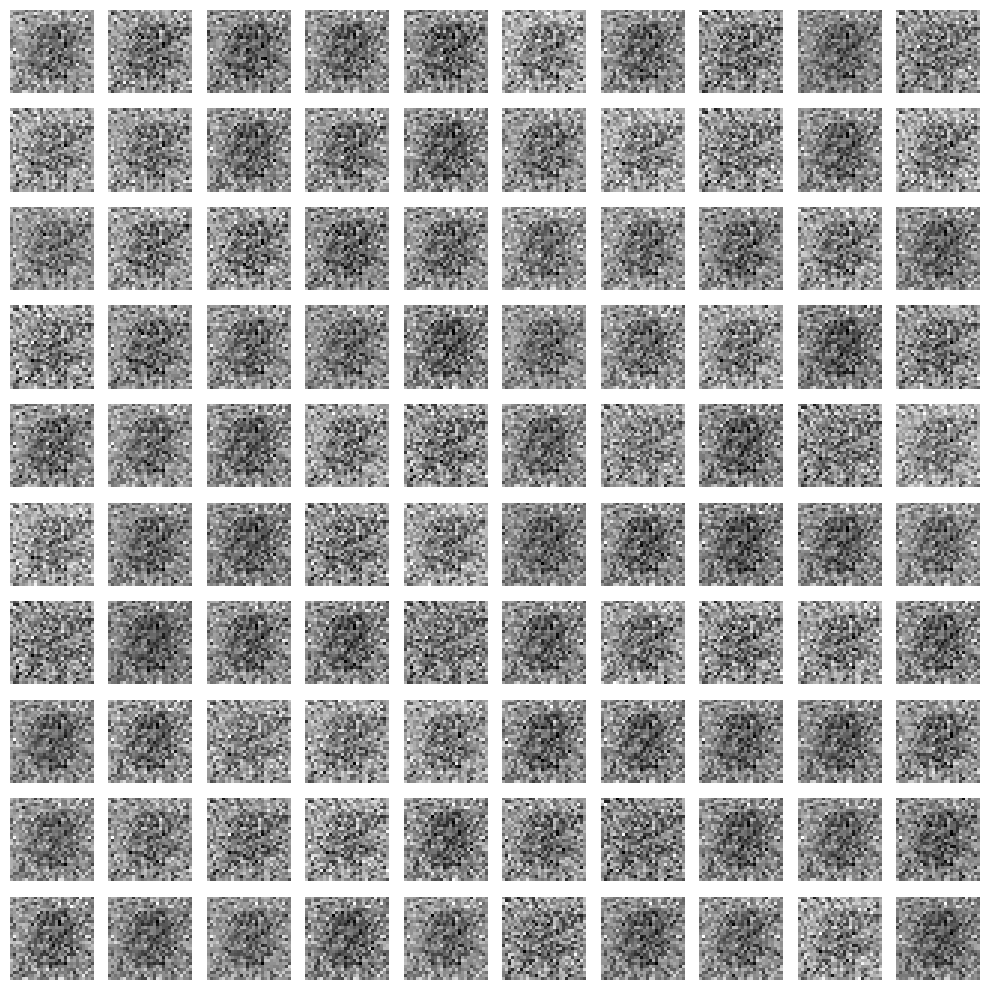

In [13]:
train(20, 128)

1. First, we load the data and split the data into several batches to feed into our model
2. Here we just initialize our GAN network based on the methods defined above
3. This is our training loop, where we run for the specified number of epochs.
4. We generate some random noise and take out some images from our dataset
5. We generate some images using the generator and create a vector X that has some fake images and some real images
6. We create a vector Y which has the “correct answers” that corresponds to X, with the fake images labeled 0 and the real images labeled 0.9. They’re labeled 0.9 instead of 1 because it helps the GAN train better, a method called one-sided label smoothing.
7. We need to alternate the training between the discriminator and generator, so over here, we update the discriminator
8. Finally, we update the discriminator.